<a href="https://colab.research.google.com/github/arjunparmar/VIRTUON/blob/main/Image_seg%20unet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
from google.colab import drive
drive.mount('/content/drive')

import tensorflow as tf
import os as os
import random
import numpy as np
import json
from tqdm import tqdm 
import pandas as pd
import matplotlib.pyplot as plt

from skimage.io import imread, imshow
from skimage.transform import resize
from tensorflow import keras
from keras.preprocessing.image import load_img,img_to_array
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import Conv2D, Flatten, Dense, Input, Conv2DTranspose,MaxPool2D
from tensorflow.keras.layers import concatenate, Activation, MaxPooling2D, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from keras.optimizers import Adam
from keras.losses import binary_crossentropy
from tensorflow.keras.utils import Sequence,to_categorical


from keras.metrics import MeanIoU
import tensorflow.keras.backend as K


np.random.seed(42)



Mounted at /content/drive


In [8]:

BASE_DIR = '/content/drive/Shareddrives/Virtuon/Clothing Co-Parsing Dataset'



IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 3

In [12]:
metadata_df = pd.read_csv(os.path.join(BASE_DIR,'metadata.csv'))
metadata_df = metadata_df[['image_path','label_type','label_path']]
metadata_df['image_path'] =  metadata_df['image_path'].apply(lambda im_path: os.path.join(BASE_DIR,im_path))
metadata_df['label_path'] =  metadata_df['label_path'].apply(lambda l_path: os.path.join(BASE_DIR,'labels',l_path))

#Selecting pixel level annoted dataset only
metadata_df = metadata_df[metadata_df['label_type'] == 'pixel-level']

#shuffle dataframe
metadata_df = metadata_df.sample(frac=1).reset_index(drop=True)

#train / val split 0.05
valid_df = metadata_df.sample(frac=.1,random_state=42)
train_df = metadata_df.drop(valid_df.index)

print("No. of test images " , len(valid_df),"\nNo. of train images " ,len(train_df))


class_dict = pd.read_csv(os.path.join(BASE_DIR,'class_dict.csv')).drop(index=[1,2,3,9,15,29,34,33,56,57])

classes_name = class_dict['class_name'].tolist() #series
classes_name[0] = 'none'

classes_rgb = class_dict[['r','g','b']].values.tolist() #values will be tensors
print("#classes = ",len(class_dict))
print("classes and their rgb values are " , classes_name)
print(classes_rgb)

No. of test images  100 
No. of train images  904
#classes =  49
classes and their rgb values are  ['none', 'blazer', 'blouse', 'bodysuit', 'boots', 'bra', 'cape', 'cardigan', 'clogs', 'coat', 'dress', 'flats', 'glasses', 'gloves', 'hair', 'hat', 'heels', 'hoodie', 'intimate', 'jacket', 'jeans', 'jumper', 'leggings', 'loafers', 'panties', 'pants', 'pumps', 'romper', 'sandals', 'scarf', 'shirt', 'shoes', 'shorts', 'skin', 'skirt', 'sneakers', 'socks', 'stockings', 'suit', 'sunglasses', 'sweater', 'sweatshirt', 'swimwear', 't-shirt', 'tie', 'tights', 'top', 'vest', 'wedges']
[[69, 6, 90], [72, 30, 112], [72, 35, 116], [71, 40, 120], [70, 47, 124], [69, 52, 127], [66, 61, 132], [64, 67, 135], [62, 72, 136], [61, 76, 137], [58, 82, 139], [54, 90, 140], [52, 94, 141], [50, 99, 141], [48, 103, 141], [46, 107, 142], [45, 111, 142], [43, 116, 142], [41, 120, 142], [40, 123, 142], [38, 127, 142], [36, 132, 141], [35, 136, 141], [34, 139, 141], [31, 148, 139], [30, 152, 138], [30, 155, 137], [34

In [10]:
cloth = ['shirt','sweater','sweatshirt','t-shirt','tie','top','vest','blazer', 'blouse', 'bra', 'cardigan', 'coat', 'hoodie', 'jacket',
       'jumper', 'romper','suit','swimwear','bodysuit', 'cape', 'dress', 'intimate','pumps','sandals','shoes','sneakers','socks',
       'wedges','clogs', 'flats', 'heels', 'loafers', 'boots','skirt','stockings','tights', 'jeans', 'leggings', 'panties',
       'pants','shorts']
hair = ['hair', 'hat']
skin = ['skin','scarf','sunglasses', 'glasses', 'gloves']
bg = ['none']
print(len(cloth) + len(hair) + len(skin) + len(bg) )

49


In [24]:
def one_hot_mask_creator_tf(image,classes_names=classes_name,classes_rgb=classes_rgb,im_shape = (IMG_HEIGHT,IMG_WIDTH),n_classes=8):
    '''
        creates 3D tensor of one-hot-encoded mask of shape im_shape and n_classes channels
    '''
    height,width = im_shape
    t_image = [tf.zeros([height,width], dtype = tf.float32) for i in range(n_classes)]
    temp_image_1 = tf.zeros([height,width], dtype = tf.float32)
    for cls_name , rgb in zip(classes_name,classes_rgb):
        if cloth.count(cls_name) == 1: 
            value = 0
        if hair.count(cls_name) == 1:
            value = 1
        if skin.count(cls_name) == 1:
            value = 2
        if bg.count(cls_name) == 1:
            value = 3

        temp = tf.math.equal(image,rgb)
        
        temp = tf.reduce_all(temp,axis=-1)
        
        temp = tf.cast(temp, tf.float32)
        
        temp_image_1 = tf.math.add(temp_image_1, temp)

        t_image[value] = tf.math.add(t_image[value], temp)

    temp_image_1 = tf.cast(tf.math.less_equal(temp_image_1, 0), dtype = tf.float32)

    t_image[3] = tf.math.add(t_image[3], temp_image_1)

    for i in range(8):
        t_image[i] = tf.cast(tf.math.greater_equal(t_image[i], 1), dtype = tf.float32)

    mask = tf.stack(t_image, axis = -1)

    return mask

In [25]:
index = 6
img_path = train_df['label_path'][index]
x = train_df['image_path'][index]
mask = one_hot_mask_creator_tf(img_to_array(load_img(img_path,target_size=(256,256),color_mode="rgb",interpolation='bilinear')))



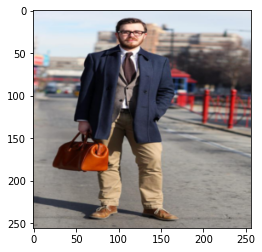

In [26]:
plt.imshow(img_to_array(load_img(x,target_size=(256,256),color_mode="rgb",interpolation='bilinear')) / 255.0)

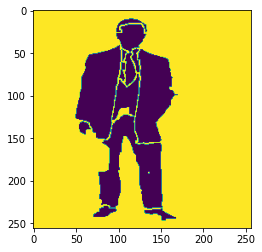

In [27]:
plt.imshow(mask[:,:,3])

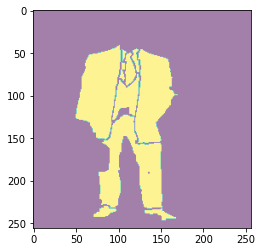

In [28]:
plt.imshow(mask[:,:,0],alpha = 0.5)

In [29]:
def one_hot_mask_decoder(masks,classes_rgb=classes_rgb,im_shape=(IMG_HEIGHT,IMG_WIDTH)):
  # mask size = (im_h,im_w,n_classes)
  # classes_rgb = np.array(classes_rgb)
  high_indexes = np.argmax(masks,axis=-1)
  color_codes =  np.array(classes_rgb)
  label = color_codes[high_indexes]
  return label

In [30]:
def parse_function(filename, label):
    image_string = tf.io.read_file(filename)
 
    #Don't use tf.image.decode_image, or the output shape will be undefined
    image = tf.io.decode_png(image_string, channels=3)
 
    #This will convert to float values in [0, 1]
    image = tf.image.convert_image_dtype(image, tf.float32)

    resized_image = tf.image.resize(image, [256, 256])
 
    image_string = tf.io.read_file(label)
 
    #Don't use tf.image.decode_image, or the output shape will be undefined
    label = tf.io.decode_png(image_string, channels=3)
    
    #This will convert to float values in [0, 1]
    # image = tf.image.convert_image_dtype(image, tf.float32)
    
    label = tf.image.resize(label, [256, 256])
 
    label = one_hot_mask_creator_tf(label)
    print(label.shape)
    print(resized_image)
 
    return resized_image, label

In [31]:
filenames = train_df['image_path'].values
labels = train_df['label_path'].values

dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
dataset = dataset.shuffle(len(filenames))
dataset = dataset.map(parse_function, num_parallel_calls=tf.data.experimental.AUTOTUNE)
# dataset = dataset.map(train_preprocess, num_parallel_calls=4)
dataset = dataset.batch(8).repeat()
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

(256, 256, 8)
Tensor("resize/Squeeze:0", shape=(256, 256, 3), dtype=float32)


In [32]:

def conv_2d_block(x,n_filters,k_size,batchnorm=False):
  ''' add two Conv layers with relu activation '''
  #first layer
  x = Conv2D(filters=n_filters,kernel_size=(k_size,k_size) , 
             padding='same', kernel_initializer = 'he_normal')(x)
  if batchnorm:
    x = BatchNormalization()(x)
  x = Activation('relu')(x)
  # 2nd layer
  x = Conv2D(filters=n_filters,kernel_size=(k_size,k_size) , 
              padding='same', kernel_initializer = 'he_normal')(x)
  if batchnorm:
      x = BatchNormalization()(x)
  x = Activation('relu')(x)
  return x

def get_u_net(input,n_filters=16,conv_k_size=3,pool_size=2,batchnorm=True,dropout=.2):

  c1 = conv_2d_block(input,n_filters * 1 , conv_k_size,batchnorm)
  p1 = MaxPool2D(pool_size=(pool_size,pool_size))(c1)
  p1 = Dropout(dropout)(p1)

  c2 = conv_2d_block(p1,n_filters * 2 , conv_k_size,batchnorm)
  p2 = MaxPool2D(pool_size=(pool_size,pool_size))(c2)
  p2 = Dropout(dropout)(p2)

  c3 = conv_2d_block(p2,n_filters * 4 , conv_k_size,batchnorm)
  p3 = MaxPool2D(pool_size=(pool_size,pool_size))(c3)
  p3 = Dropout(dropout)(p3)
 
  c4 = conv_2d_block(p3,n_filters * 8 , conv_k_size,batchnorm)
  p4 = MaxPool2D(pool_size=(pool_size,pool_size))(c4)
  p4 = Dropout(dropout)(p4)

  c5 = conv_2d_block(p4,n_filters * 16 , conv_k_size,batchnorm)

   #Up sampling
  u6 = Conv2DTranspose(filters=n_filters * 8 ,kernel_size=(3,3), strides=(2,2),padding='same')(c5)
  u6 = concatenate([u6,c4])
  u6 = Dropout(dropout)(u6)
  c7 = conv_2d_block(u6,n_filters * 8 , conv_k_size,batchnorm)

  u8 = Conv2DTranspose(filters=n_filters * 4 ,kernel_size=(3,3), strides=(2,2),padding='same')(c7)
  u8 = concatenate([u8,c3])
  u8 = Dropout(dropout)(u8)
  c9 = conv_2d_block(u8,n_filters * 4 , conv_k_size,batchnorm)

  u10 = Conv2DTranspose(filters=n_filters * 2,kernel_size=(3,3) , strides=(2,2),padding='same')(c9)
  u10 = concatenate([u10,c2])
  u10 = Dropout(dropout)(u10)
  c11 = conv_2d_block(u10,n_filters * 2 , conv_k_size,batchnorm)

  u12 = Conv2DTranspose(filters=n_filters * 1 ,kernel_size=(3,3), strides=(2,2),padding='same')(c11)
  u12 = concatenate([u12,c1])
  u12 = Dropout(dropout)(u12)
  c13 = conv_2d_block(u12,n_filters * 1 , conv_k_size,batchnorm)

  output = Conv2D(filters=8 , kernel_size=(1,1),activation='softmax')(c13) 
  # output layer
  model = Model(inputs=input,outputs=output,name='classifier')
  return model

In [33]:
import tensorflow.keras.backend as K

def DiceBCELoss(targets, inputs, smooth=1e-6):    
       
    #flatten label and prediction tensors
    inputs = K.flatten(inputs)
    targets = K.flatten(targets)

    inputs = K.expand_dims(inputs,0)
    targets = K.expand_dims(targets,0)
    BCE =  binary_crossentropy(targets, inputs)
    intersection = K.sum(K.dot(targets, K.transpose(inputs)))    
    dice_loss = 1 - (2*intersection + smooth) / (K.sum(targets) + K.sum(inputs) + smooth)
    # Dice_BCE = BCE + dice_loss
    
    return 1 - dice_loss

def IoULoss(targets, inputs, smooth=1e-6):
    
    #flatten label and prediction tensors
    inputs = K.flatten(inputs)
    targets = K.flatten(targets)

    inputs = K.expand_dims(inputs,0)
    targets = K.expand_dims(targets,0)
    
    intersection = K.sum(K.dot(targets, K.transpose(inputs)))
    total = K.sum(targets) + K.sum(inputs)
    union = total - intersection
    
    IoU = (intersection + smooth) / (union + smooth)
    return 1 - IoU


ALPHA = 0.5
BETA = 0.5

def TverskyLoss(targets, inputs, alpha=ALPHA, beta=BETA, smooth=1e-6):
        
        #flatten label and prediction tensors
        inputs = K.flatten(inputs)
        targets = K.flatten(targets)
        
        #True Positives, False Positives & False Negatives
        TP = K.sum((inputs * targets))
        FP = K.sum(((1-targets) * inputs))
        FN = K.sum((targets * (1-inputs)))
       
        Tversky = (TP + smooth) / (TP + alpha*FP + beta*FN + smooth)  
        
        return 1 - Tversky

In [34]:
optimizer = Adam(learning_rate=1e-4)
loss      = TverskyLoss
metrics   = [MeanIoU(8)]

# Compile our model
input = Input(shape=(IMG_HEIGHT,IMG_HEIGHT,3),name='img')
model = get_u_net(input,n_filters=64,batchnorm=True,)


model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [35]:
callback = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=1e-5, verbose=1),
    tf.keras.callbacks.TensorBoard(log_dir= os.path.join(BASE_DIR,'taksh/logs')),
    tf.keras.callbacks.ModelCheckpoint(os.path.join(BASE_DIR,'taksh')
                    ,verbose=1
                    ,save_weights_only=True
                    ,save_best_only=True,
                    monitor='val_mean_io_u',
                    mode='max'
                    )
    ]

In [36]:
params = {
      'batch_size' : 8,
      'n_channels' : 3,
       'n_classes' : 8,
        'im_shape' : (IMG_HEIGHT,IMG_WIDTH),   
        'shuffle' : True,   
}

In [37]:
filenames_test = valid_df['image_path'].values
labels_test = valid_df['label_path'].values

valid_dataset = tf.data.Dataset.from_tensor_slices((filenames_test, labels_test))
valid_dataset = valid_dataset.shuffle(len(filenames_test))
valid_dataset = valid_dataset.map(parse_function, num_parallel_calls=tf.data.experimental.AUTOTUNE)
valid_dataset = valid_dataset.batch(8)
valid_dataset = valid_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

(256, 256, 8)
Tensor("resize/Squeeze:0", shape=(256, 256, 3), dtype=float32)


In [ ]:
results = model.fit(x=dataset,
          epochs=50,
           verbose=1,
           callbacks=callback,
           validation_data = valid_dataset,
                  use_multiprocessing=True,
                    workers=6, steps_per_epoch = 113)
%time

Epoch 1/50
113/113 [==============================] - 332s 3s/step - loss: 0.4621 - mean_io_u: 0.4375 - val_loss: 0.4130 - val_mean_io_u: 0.4375

Epoch 00001: val_mean_io_u improved from -inf to 0.43750, saving model to /content/drive/Shareddrives/Virtuon/Clothing Co-Parsing Dataset/taksh
Epoch 2/50
113/113 [==============================] - 90s 795ms/step - loss: 0.2812 - mean_io_u: 0.4375 - val_loss: 0.3030 - val_mean_io_u: 0.4375

Epoch 00002: val_mean_io_u did not improve from 0.43750
Epoch 3/50
113/113 [==============================] - 88s 780ms/step - loss: 0.2301 - mean_io_u: 0.4375 - val_loss: 0.2350 - val_mean_io_u: 0.4375

Epoch 00003: val_mean_io_u did not improve from 0.43750
Epoch 4/50
113/113 [==============================] - 89s 787ms/step - loss: 0.1939 - mean_io_u: 0.4375 - val_loss: 0.1819 - val_mean_io_u: 0.4375

Epoch 00004: val_mean_io_u did not improve from 0.43750
Epoch 5/50
113/113 [==============================] - 89s 785ms/step - loss: 0.1662 - mean_io_u: 0

In [38]:
x = train_df['image_path'][6]
y_true = train_df['label_path'][6]
x = img_to_array(load_img(x,target_size=(256,256),color_mode="rgb",interpolation='bilinear'))
y_true = img_to_array(load_img(y_true,target_size=(256,256),color_mode="rgb",interpolation='bilinear'))

In [39]:
mask = model.predict(x.reshape(1,256,256,3))

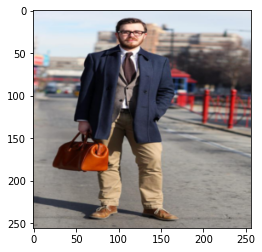

In [40]:
plt.imshow(x/255.0)

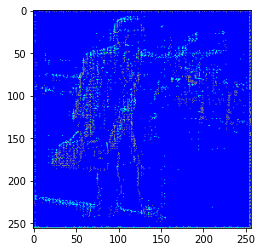

In [41]:
decoded_mask = one_hot_mask_decoder(masks=mask.squeeze(),classes_rgb=[(128,128,128),(192,192,192),(255,0,255), (0,255,255),(255,255,0),(0,0,255), (0,255,0),(255,0,0)])
plt.imshow(decoded_mask)

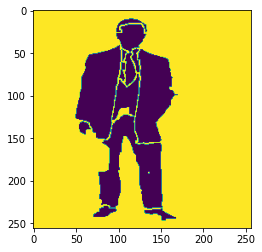

In [42]:
plt.imshow(one_hot_mask_creator_tf(y_true)[:,:,3])